# Store the JSON data to csv

The goal of this notebook is to test the store data functions.

In [14]:
import os
import pandas as pd

from re_forecast.data.load_data import download_rte_data
from re_forecast.data.format_data import extract_generation_units, extract_generation_values, extract_all_generation_values
from re_forecast.data.store_data import create_csv_path_units_names, create_csv_path
from re_forecast.data.store_data import store_to_csv
from re_forecast.params import DATA_CSV_ENERGY_PRODUCTION_PATH

## 1/ Store the units names

We want to store the units names for each of the three ressources, by calling the RTE API without any parameters.

In [2]:
# Set all the params to None
start_date = None
end_date = None
eic_code = None
prod_type = None
prod_subtype = None

# We want to iterate over the three ressources
ressources = [1, 2, 3]

for ressource in ressources:
    # Download the RTE data
    data = download_rte_data(ressource,
                             start_date,
                             end_date,
                             eic_code,
                             prod_type,
                             prod_subtype)

    # Format the data in order to extract the units names
    format_data = extract_generation_units(data, ressource)

    # Store each units list into csv
    store_to_csv(format_data,
                 DATA_CSV_ENERGY_PRODUCTION_PATH,
                 ressource,
                 start_date,
                 end_date,
                 eic_code,
                 prod_type,
                 prod_subtype,
                 store_units_names = True)

## 2/ Show the units names for all ressources

In [3]:
# Iterate for the three ressources
ressources = [1, 2, 3]

for ressource in ressources:
    try:
        # Construct the csv path
        csv_path = create_csv_path_units_names(DATA_CSV_ENERGY_PRODUCTION_PATH,
                                            ressource)

        # Read units names csv into a df
        units_names = pd.read_csv(csv_path)

        # Display units names for the ressource
        display(units_names)

    except:
        display(f"Units for ressource n°{ressource} contain no lines")
        pass

,production_type
0,BIOMASS
1,FOSSIL_GAS
2,FOSSIL_HARD_COAL
3,FOSSIL_OIL
4,HYDRO_PUMPED_STORAGE
5,HYDRO_RUN_OF_RIVER_AND_POUNDAGE
6,HYDRO_WATER_RESERVOIR
7,NUCLEAR
8,SOLAR
9,WASTE


,eic_code,name,production_type
0,17W000001023725I,FR_LANDIVISIAUGU,FOSSIL_GAS
1,17W000001418626A,CPCU-CogeVitry–GP,FOSSIL_GAS
2,17W0000014186456,CPCU-StOuen-GP,FOSSIL_GAS
3,17W0000014455651,BANC DE GUERANDE 1,WIND_OFFSHORE
4,17W000001445567Y,BANC DE GUERANDE 2,WIND_OFFSHORE
...,...,...,...
138,17W100P100P0361D,BATHIE 6,HYDRO_WATER_RESERVOIR
139,17W100P100P03655,PROVENCE 4 BIOMASSE,BIOMASS
140,17W100P100P0842Y,A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE
141,17W100P100P20746,COCHE 5,HYDRO_PUMPED_STORAGE


,production_type,production_subtype
0,BIOENERGY,BIOGAS
1,BIOENERGY,BIOMASS
2,BIOENERGY,TOTAL
3,BIOENERGY,WASTE
4,FOSSIL_GAS,FOSSIL_GAS_CCGT
5,FOSSIL_GAS,FOSSIL_GAS_CHP
6,FOSSIL_GAS,FOSSIL_GAS_CT
7,FOSSIL_GAS,FOSSIL_GAS_OTHER
8,FOSSIL_GAS,TOTAL
9,FOSSIL_HARD_COAL,TOTAL


## 3/ Store the generation values

First try with default API call

In [15]:
# Define the slice_df function; see bellow for its usage
def slice_df(df: pd.DataFrame,
             ressource_nb: int,
             row_rules = {1: 0,
                          2: 0,
                          3: "production_type in ['NUCLEAR', 'PUMPING', 'SOLAR', 'WIND'] or production_subtype not in ['TOTAL']"},
             col_rules = {1: "production_type",
                          2: "eic_code",
                          3: "production_subtype"}
             ) -> pd.Series:
    """Slice a df following the rule dict. The dict
    specified a rule given each ressource nb.
    If the row rule indicate '0', no slice is undertake.
    Else, the slice is made given the number of rows (exclusive)
    The col_rules indicate a column to pick within the df."""

    # Set the rule for rows and cols
    row_rule = row_rules[ressource_nb]
    col_rule = col_rules[ressource_nb]

    # If the rule specify '0', don't slice
    if row_rule == 0:
        # Just make a selection for the cols
        return df.loc[:, col_rule]

    # Make a selection for the rows using query
    df = df.query(row_rule)

    # Make the selection for the cols and return
    return df.loc[:, col_rule]

In [17]:
# Set all the params to None
start_date = None
end_date = None
eic_code = None
prod_type = None
prod_subtype = None

# We want to iterate over the three ressources
ressources = [1, 2, 3]

for ressource in ressources:
    # Download the RTE data
    data = download_rte_data(ressource,
                             start_date,
                             end_date,
                             eic_code,
                             prod_type,
                             prod_subtype)

    # Read the units names from their directory
    # Construct the csv path
    csv_path = create_csv_path_units_names(DATA_CSV_ENERGY_PRODUCTION_PATH,
                                           ressource)

    # Read units names csv into a df
    units_names = pd.read_csv(csv_path)

    # Use a special slice rule for ressource

    # Slice the df following a rule; use (construct) the slice_df function
    # Use the slice function for ressources 1 and 2
    units_names = slice_df(units_names, ressource)

    # Transform the resulting pd.serie above into list
    units_names_list = units_names.to_list()

    # Format the data in order to extract the units names
    format_data = extract_all_generation_values(data,
                                                ressource,
                                                units_names_list)

    # Store each units list into csv
    store_to_csv(format_data,
                 DATA_CSV_ENERGY_PRODUCTION_PATH,
                 ressource,
                 start_date,
                 end_date,
                 eic_code,
                 prod_type,
                 prod_subtype,
                 store_units_names = False)

The file /home/bender/Data/personal_data_projects/renewable_energy_forecast/csv/energy_production/actual_generations_per_production_type__2024-2-8_23:00:00__all-units.csv already exists.
The server encounter an error when the function 'download_rte_data' call the API
{'error': 'ACTUALGEN_COMMON_T05', 'error_description': 'Internal Server Error.', 'error_uri': '', 'error_details': {'transaction_id': 'Id-4653c565f9371a410d72420d'}}
The JSON return by the API is not at the right format, the API may encounter an issue
None
The function format_data malfuncitoned, due to a problem in the API call
None


## 4/ Show the values for all ressources

In [18]:
# Iterate for the three ressources
ressources = [1, 2, 3]

for ressource in ressources:
    try:
        # Construct the csv path
        csv_path = create_csv_path(DATA_CSV_ENERGY_PRODUCTION_PATH,
                                   ressource)

        # Read values csv into a df
        values = pd.read_csv(csv_path)

        # Display values for the ressource
        display(values.head(10))

        # Display shape for values
        display(values.shape)

    except:
        display(f"Values for ressource n°{ressource} contain no lines")
        pass

,start_date,end_date,updated_date,value,unit_name
0,2024-02-08T00:00:00+01:00,2024-02-08T01:00:00+01:00,2024-02-08T00:35:47+01:00,319,BIOMASS
1,2024-02-08T01:00:00+01:00,2024-02-08T02:00:00+01:00,2024-02-08T01:35:46+01:00,320,BIOMASS
2,2024-02-08T02:00:00+01:00,2024-02-08T03:00:00+01:00,2024-02-08T02:35:49+01:00,319,BIOMASS
3,2024-02-08T03:00:00+01:00,2024-02-08T04:00:00+01:00,2024-02-08T03:35:54+01:00,318,BIOMASS
4,2024-02-08T04:00:00+01:00,2024-02-08T05:00:00+01:00,2024-02-08T04:35:41+01:00,321,BIOMASS
5,2024-02-08T05:00:00+01:00,2024-02-08T06:00:00+01:00,2024-02-08T05:35:45+01:00,321,BIOMASS
6,2024-02-08T06:00:00+01:00,2024-02-08T07:00:00+01:00,2024-02-08T06:35:44+01:00,322,BIOMASS
7,2024-02-08T07:00:00+01:00,2024-02-08T08:00:00+01:00,2024-02-08T07:35:55+01:00,320,BIOMASS
8,2024-02-08T08:00:00+01:00,2024-02-08T09:00:00+01:00,2024-02-08T08:35:50+01:00,320,BIOMASS
9,2024-02-08T09:00:00+01:00,2024-02-08T10:00:00+01:00,2024-02-08T09:35:52+01:00,317,BIOMASS


(286, 5)

'Values for ressource n°2 contain no lines'

,start_date,end_date,updated_date,value,unit_name
0,2024-02-08T00:00:00+01:00,2024-02-08T00:15:00+01:00,2024-02-08T23:14:16+01:00,249,BIOGAS
1,2024-02-08T00:15:00+01:00,2024-02-08T00:30:00+01:00,2024-02-08T23:14:16+01:00,249,BIOGAS
2,2024-02-08T00:30:00+01:00,2024-02-08T00:45:00+01:00,2024-02-08T23:14:16+01:00,249,BIOGAS
3,2024-02-08T00:45:00+01:00,2024-02-08T01:00:00+01:00,2024-02-08T23:14:16+01:00,249,BIOGAS
4,2024-02-08T01:00:00+01:00,2024-02-08T01:15:00+01:00,2024-02-08T23:14:17+01:00,249,BIOGAS
5,2024-02-08T01:15:00+01:00,2024-02-08T01:30:00+01:00,2024-02-08T23:14:17+01:00,249,BIOGAS
6,2024-02-08T01:30:00+01:00,2024-02-08T01:45:00+01:00,2024-02-08T23:14:18+01:00,249,BIOGAS
7,2024-02-08T01:45:00+01:00,2024-02-08T02:00:00+01:00,2024-02-08T23:14:18+01:00,249,BIOGAS
8,2024-02-08T02:00:00+01:00,2024-02-08T02:15:00+01:00,2024-02-08T23:14:19+01:00,249,BIOGAS
9,2024-02-08T02:15:00+01:00,2024-02-08T02:30:00+01:00,2024-02-08T23:14:19+01:00,249,BIOGAS


(1593, 5)

<Axes: xlabel='start_date', ylabel='value'>

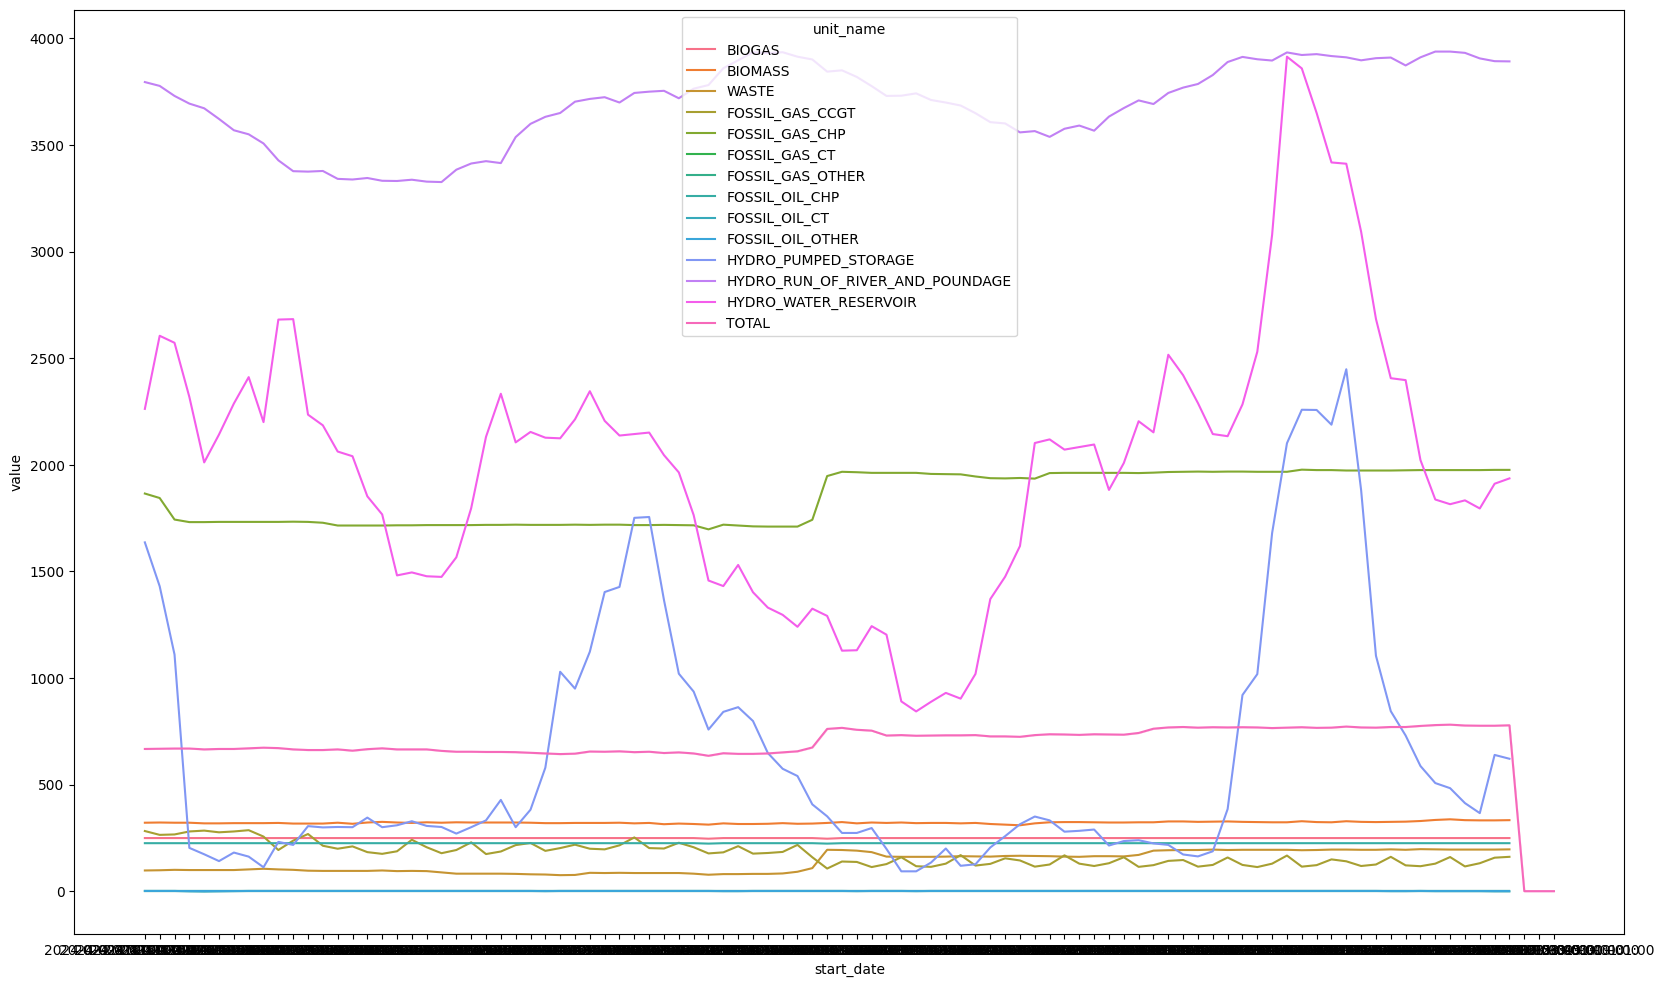

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 12))
sns.lineplot(data = values, x = 'start_date', y = 'value', hue = 'unit_name')